In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import SAGEConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import BallTree
from math import radians
from statsmodels.tsa.stattools import acf
import numpy as np
import matplotlib.pyplot as plt

class Time2VecEncoding(nn.Module):
    """Time2Vec encoding for temporal features"""
    def __init__(self, h_dim, scale=1):
        super(Time2VecEncoding, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(1, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(1, h_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(h_dim-1))
        self.f = torch.sin
        self.scale = scale

    def forward(self, time):
        # Ensure time is 2D: [batch_size, 1]
        if len(time.shape) == 1:
            time = time.unsqueeze(-1)
        elif len(time.shape) == 3:
            # If time has shape [batch_size, seq_len, 1], take the last time step
            time = time[:, -1, :].unsqueeze(-1)
            
        # Scale time
        time = time / self.scale
        
        # Calculate linear and periodic components
        v1 = torch.matmul(time, self.w0) + self.b0  # Shape: [batch_size, 1]
        v2 = self.f(torch.matmul(time, self.w) + self.b)  # Shape: [batch_size, h_dim-1]
        
        return torch.cat([v1, v2], dim=1)  # Shape: [batch_size, h_dim]

class STRAP(nn.Module):
    """Improved ST-RAP model with true sequence processing"""
    def __init__(self, seq_length, input_dim, hidden_dim=128, num_gru_layers=2):
        super(STRAP, self).__init__()
        
        self.seq_length = seq_length
        
        # Price sequence embedding
        self.price_encoder = nn.Linear(1, hidden_dim)
        
        # Property feature embedding
        self.property_embedding = nn.Linear(input_dim, hidden_dim)
        
        # Temporal GRU layers for processing price sequences
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_gru_layers,
            batch_first=True
        )
        self.temporal_norm = nn.LayerNorm(hidden_dim)
        
        # Spatial graph layers
        self.graph_conv = SAGEConv(hidden_dim, hidden_dim)
        self.spatial_norm = nn.LayerNorm(hidden_dim)
        
        # Attention mechanism to focus on relevant parts of the sequence
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Final prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, price_history, property_features, edge_index=None):
        batch_size = price_history.size(0)
        
        # Reshape price history to [batch_size, seq_length, 1]
        if len(price_history.shape) == 2:
            price_history = price_history.unsqueeze(-1)
        
        # Encode price history
        price_encoded = self.price_encoder(price_history)  # [batch_size, seq_length, hidden_dim]
        
        # Process with GRU
        gru_output, _ = self.gru(price_encoded)  # [batch_size, seq_length, hidden_dim]
        
        # Apply attention to focus on most relevant timesteps
        attention_weights = self.attention(gru_output)  # [batch_size, seq_length, 1]
        context_vector = torch.sum(attention_weights * gru_output, dim=1)  # [batch_size, hidden_dim]
        temporal_output = self.temporal_norm(context_vector)
        
        # Process property features
        property_emb = self.property_embedding(property_features)
        
        # Process with graph convolution if edge_index provided
        if edge_index is not None and edge_index.numel() > 0:
            spatial_output = self.graph_conv(property_emb, edge_index)
            spatial_output = self.spatial_norm(spatial_output)
        else:
            spatial_output = property_emb
        
        # Combine temporal and spatial outputs
        combined = torch.cat([temporal_output, spatial_output], dim=1)
        
        # Final prediction
        output = self.predictor(combined).squeeze(-1)
        
        return output

def create_edge_index_efficient(data, k_neighbors=5, distance_threshold=2.0, chunk_size=1000):
    """
    Create spatial edge index efficiently using BallTree and chunking
    """
    print("Creating spatial edge index efficiently...")
    coords = data[['latitude', 'longitude']].values
    n_samples = len(coords)
    
    # Convert to radians for BallTree
    coords_rad = np.radians(coords)
    
    # Create BallTree
    tree = BallTree(coords_rad, metric='haversine')
    
    # Create edge index
    edge_index = []
    
    # Process in chunks to avoid memory issues
    for i in tqdm(range(0, n_samples, chunk_size)):
        end_idx = min(i + chunk_size, n_samples)
        chunk_coords = coords_rad[i:end_idx]
        
        # Query k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Convert distances from radians to km
        distances = distances * 6371.0  # Earth radius in km
        
        # Add edges for each point in chunk
        for j in range(len(chunk_coords)):
            point_idx = i + j
            for k in range(1, k_neighbors+1):  # Skip self (index 0)
                neighbor_idx = indices[j, k]
                distance = distances[j, k]
                
                if distance <= distance_threshold:
                    edge_index.append([point_idx, neighbor_idx])
                    # Add reverse edge for undirected graph
                    edge_index.append([neighbor_idx, point_idx])
    
    # Remove duplicates
    edge_index = list(set(tuple(edge) for edge in edge_index))
    edge_index = [list(edge) for edge in edge_index]
    
    return torch.tensor(edge_index, dtype=torch.long).t()

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Create spatial features similar to XGBoost implementation"""
    print("Creating spatial features...")
    city_center_lat, city_center_lon = 48.8566, 2.3522  # Paris coordinates
    
    # Calculate distance to city center and north-south position
    df['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    )
    
    df['north_south'] = df['latitude'] - city_center_lat
    
    # Create BallTree for nearest neighbor calculations
    coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(coords, metric='haversine')
    
    # Process in chunks
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    # KNN features
    knn_price_mean = np.zeros(len(df))
    knn_price_std = np.zeros(len(df))
    knn_price_median = np.zeros(len(df))
    price_diff = np.zeros(len(df))
    
    start_idx = 0
    for chunk in tqdm(chunks, desc="Processing chunks"):
        chunk_size = len(chunk)
        chunk_coords = np.radians(chunk[['latitude', 'longitude']].values)
        
        # Find k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Calculate neighbor statistics
        for i in range(chunk_size):
            # Skip self (index 0)
            neighbor_indices = indices[i, 1:]
            prices = df.iloc[neighbor_indices]['price'].values
            
            # Calculate statistics
            knn_price_mean[start_idx + i] = np.mean(prices)
            knn_price_std[start_idx + i] = np.std(prices)
            knn_price_median[start_idx + i] = np.median(prices)
            price_diff[start_idx + i] = chunk.iloc[i]['price'] - np.mean(prices)
        
        start_idx += chunk_size
    
    # Add features to dataframe
    df['knn_price_mean'] = knn_price_mean
    df['knn_price_std'] = knn_price_std
    df['knn_price_median'] = knn_price_median
    df['price_diff_from_neighbors'] = price_diff
    
    # Standardize the new features
    spatial_features = ['distance_to_center', 'north_south', 
                        'knn_price_mean', 'knn_price_std', 
                        'knn_price_median', 'price_diff_from_neighbors']
    
    for col in spatial_features:
        mean_val = df[col].mean()
        std_val = df[col].std()
        if std_val > 0:
            df[col] = (df[col] - mean_val) / std_val
    
    return df

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_strap_prediction(train_path, test_path, features_to_drop=None, prediction_days=7, output_path=None):
    """Run ST-RAP model with day-by-day retraining for multiple days prediction"""
    print(f"Processing dataset for {prediction_days}-day prediction")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    print(f"Features being dropped: {features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Add spatial features to enhance prediction
    train_data = create_spatial_features(train_data)
    test_data = create_spatial_features(test_data)
    
    # Create feature matrices    
    feature_cols = [col for col in train_data.columns 
                  if col not in ['listing_id', 'date', 'price']]
    
    X_train = train_data[feature_cols].values
    y_train = train_data['price'].values
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = STRAP(
        input_dim=len(feature_cols),
        temporal_dim=5,  # Temporal features: day, month, weekend, season_sin, season_cos
        hidden_dim=128
    ).to(device)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Define loss function
    criterion = nn.MSELoss()
    
    # Initialize results storage
    daily_results = []
    
    # We won't use graph structure to avoid computational overhead
    # Set edge_index to None
    edge_index = None
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        X_test_day = day_test[feature_cols].values
        y_test_day = day_test['price'].values
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)
        X_test_tensor = torch.FloatTensor(X_test_day).to(device)
        y_test_tensor = torch.FloatTensor(y_test_day).to(device)
        
        # Extract time features
        time_cols = ['DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos']
        if all(col in train_data.columns for col in time_cols):
            time_features_train = torch.FloatTensor(train_data[time_cols].values).to(device)
            time_features_test = torch.FloatTensor(day_test[time_cols].values).to(device)
        else:
            # If time columns don't exist, create dummy time features
            print("Warning: Time columns not found. Using dummy time features.")
            time_features_train = torch.zeros((len(X_train_tensor), 5), device=device)
            time_features_test = torch.zeros((len(X_test_tensor), 5), device=device)
        
        # Create DataLoader for training
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, time_features_train, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Train model
        model.train()
        epochs = 3  # Reduced epochs for faster training
        
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            for batch_x, batch_time, batch_y in train_loader:
                # Forward pass - pass None for edge_index
                outputs = model(batch_x, None, batch_time)
                
                # Calculate loss
                loss = criterion(outputs, batch_y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
            
            # Print epoch stats
            avg_loss = total_loss/batch_count if batch_count > 0 else 0
            print(f"Day: {day}, Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor, None, time_features_test)
            test_loss = criterion(y_pred, y_test_tensor).item()
        
        # Convert predictions to numpy
        y_pred_np = y_pred.cpu().numpy()
        
        # Store results for the day - RENAME COLUMN TO MATCH NAIVE BASELINE
        day_results_df = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'price': y_test_day,  # Changed 'actual' to 'price' to match baseline
            'predicted': y_pred_np,
            'error': y_test_day - y_pred_np,
            'abs_error': np.abs(y_test_day - y_pred_np),
            'pct_error': np.abs((y_test_day - y_pred_np) / y_test_day) * 100
        })
        
        daily_results.append(day_results_df)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day
        X_train = np.concatenate([X_train, X_test_day])
        y_train = np.concatenate([y_train, y_test_day])
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values  # Changed from 'actual'
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values  # Changed from 'actual'
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")

    return evaluation_results

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],  # Changed from 'actual' to 'price'
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())  # Changed from 'actual' to 'price'
    max_val = max(all_results['price'].max(), all_results['predicted'].max())  # Changed from 'actual' to 'price'
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']  # Changed from 'actual' to 'price'
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== ST-RAP MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

def create_time_series_dataset(data, sequence_length=30):
    """
    Convert dataframe to time series format with sequences of historical prices
    
    Args:
        data: DataFrame with columns 'listing_id', 'date', 'price'
        sequence_length: Number of historical time steps to include
    
    Returns:
        DataFrame with time series sequences and features
    """
    # Sort by listing_id and date
    data = data.sort_values(['listing_id', 'date'])
    
    # Group by listing_id
    grouped = data.groupby('listing_id')
    
    sequences = []
    for listing_id, group in grouped:
        # If we have enough historical data
        if len(group) >= sequence_length:
            # For each possible sequence start point
            for i in range(len(group) - sequence_length):
                # Extract the sequence
                sequence = group.iloc[i:i+sequence_length+1]
                
                # Last row contains target price
                target_row = sequence.iloc[-1]
                history = sequence.iloc[:-1]
                
                # Convert price history to a list of floats
                price_history_list = history['price'].astype(float).tolist()
                
                # Create a row with historical price sequence and current features
                row_data = {
                    'listing_id': listing_id,
                    'date': target_row['date'],
                    'price_history': price_history_list,
                    'target_price': float(target_row['price'])
                }
                
                # Add current features (excluding price)
                feature_cols = [col for col in target_row.index 
                               if col not in ['listing_id', 'date', 'price']]
                for col in feature_cols:
                    row_data[col] = float(target_row[col]) if pd.notnull(target_row[col]) else 0.0
                
                sequences.append(row_data)
    
    # Convert to DataFrame
    return pd.DataFrame(sequences)

class AirbnbTimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
        # Extract feature columns (excluding special columns)
        self.feature_cols = [col for col in data.columns 
                            if col not in ['listing_id', 'date', 'price_history', 'target_price']]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Get price history as sequence
        # Convert to numpy array first to ensure it's a numeric array
        price_history = np.array(row['price_history'], dtype=np.float32)
        price_history = torch.FloatTensor(price_history)
        
        # Get features - handle each column separately to avoid object array issues
        feature_values = []
        for col in self.feature_cols:
            # Convert each value to float before adding to list
            feature_values.append(float(row[col]))
        
        features = torch.FloatTensor(feature_values)
        
        # Get target price
        target = torch.FloatTensor([float(row['target_price'])])
        
        return price_history, features, target

def run_sequence_based_prediction(train_path, test_path, sequence_length=30, prediction_days=7, output_path=None):
    """Run ST-RAP model with sequence-based prediction"""
    print(f"Processing dataset with sequence length {sequence_length} for {prediction_days}-day prediction")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Create time series datasets
    print("Creating time series sequences...")
    train_sequences = create_time_series_dataset(train_data, sequence_length)
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Create feature matrices
    feature_cols = [col for col in train_sequences.columns 
                  if col not in ['listing_id', 'date', 'price_history', 'target_price']]
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = STRAP(
        seq_length=sequence_length,
        input_dim=len(feature_cols),
        hidden_dim=128
    ).to(device)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Define loss function
    criterion = nn.MSELoss()
    
    # Initialize results storage
    daily_results = []
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Create training dataset for current state
        train_dataset = AirbnbTimeSeriesDataset(train_sequences)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Train model
        model.train()
        epochs = 2
        
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            for price_history, features, targets in train_loader:
                # Move to device
                price_history = price_history.to(device)
                features = features.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(price_history, features)
                
                # Calculate loss
                loss = criterion(outputs, targets.squeeze())
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
            
            # Print epoch stats
            avg_loss = total_loss/batch_count if batch_count > 0 else 0
            print(f"Day: {day}, Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Get test data for current day
        day_test = test_data[test_data['date'].dt.date == day].copy()
        
        # For each listing in test set, get most recent sequence
        test_sequences = []
        for listing_id in day_test['listing_id'].unique():
            # Get historical data for this listing
            listing_history = train_data[train_data['listing_id'] == listing_id].sort_values('date')
            
            if len(listing_history) >= sequence_length:
                # Take most recent sequence - convert to list of floats
                recent_sequence = listing_history.iloc[-sequence_length:]['price'].astype(float).tolist()
                test_sequences.append({
                    'listing_id': listing_id,
                    'price_history': recent_sequence
                })
        
        # Convert to DataFrame and merge with test features
        test_sequences_df = pd.DataFrame(test_sequences)
        day_test_with_seq = day_test.merge(test_sequences_df, on='listing_id', how='inner')
        
        # Skip if no sequences available
        if len(day_test_with_seq) == 0:
            print(f"No sequence data available for day {day}. Skipping.")
            continue
        
        # Create test dataset
        X_test = day_test_with_seq[feature_cols].values
        y_test = day_test_with_seq['price'].values

        # Convert price_history from a series of lists to a proper numpy array
        price_histories = []
        for ph in day_test_with_seq['price_history']:
            price_histories.append(np.array(ph, dtype=np.float32))
            
        price_history = np.array(price_histories)

        # Convert to tensors
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        price_history_tensor = torch.FloatTensor(price_history).to(device)
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            y_pred = model(price_history_tensor, X_test_tensor).cpu().numpy()
        
        # Store results
        day_results_df = pd.DataFrame({
            'date': day_test_with_seq['date'],
            'listing_id': day_test_with_seq['listing_id'],
            'price': y_test,
            'predicted': y_pred,
            'error': y_test - y_pred,
            'abs_error': np.abs(y_test - y_pred)
        })
        
        daily_results.append(day_results_df)
        
        # Update training data
        train_data = pd.concat([train_data, day_test], ignore_index=True)
        # Update sequences
        new_sequences = create_time_series_dataset(train_data, sequence_length)
        train_sequences = new_sequences
    
    # Combine all results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate metrics
    metrics = calculate_metrics(all_results)
    
    # Save results if path provided
    if output_path:
        all_results.to_csv(output_path, index=False)
    
    # Structure the return value like run_day_by_day_strap_prediction:
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)
    
    evaluation_results = {
        'overall_metrics': metrics['overall'],
        'daily_metrics': metrics['daily'],
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability
    }
    
    return evaluation_results

def calculate_metrics(results_df):
    """Calculate performance metrics"""
    y_true = results_df['price'].values
    y_pred = results_df['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    }
    
    # Group by date for daily metrics
    daily_metrics = []
    for date, group in results_df.groupby(pd.to_datetime(results_df['date']).dt.date):
        group_true = group['price'].values
        group_pred = group['predicted'].values
        
        daily_metrics.append({
            'date': date,
            'rmse': np.sqrt(mean_squared_error(group_true, group_pred)),
            'mae': mean_absolute_error(group_true, group_pred),
            'r2': r2_score(group_true, group_pred) if len(set(group_true)) > 1 else np.nan,
            'mape': np.mean(np.abs((group_true - group_pred) / (np.abs(group_true) + 1e-8))) * 100,
            'n_samples': len(group_true)
        })
    
    return {
        'overall': metrics,
        'daily': pd.DataFrame(daily_metrics)
    }

if __name__ == "__main__":
    import os
    
    # Specify paths to your data
    train_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv"
    test_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_feb.csv"
    output_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    
    # Make sure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Run prediction for 7 days and save results
    results = run_sequence_based_prediction(
        train_path=train_path,
        test_path=test_path,
        prediction_days=7,
        output_path=output_path
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_results(results)

    # Add new error analysis plots
    plot_error_analysis(results)

Processing dataset with sequence length 30 for 7-day prediction
Loading data...
Creating time series sequences...
Test set contains 7 unique dates.
Using device: cuda


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]

Day: 2024-02-09, Epoch: 1/5, Loss: 0.048515
Day: 2024-02-09, Epoch: 2/5, Loss: 0.041712
Day: 2024-02-09, Epoch: 3/5, Loss: 0.039148
Day: 2024-02-09, Epoch: 4/5, Loss: 0.037969
Day: 2024-02-09, Epoch: 5/5, Loss: 0.036705


Processing days:  14%|█▍        | 1/7 [36:30<3:39:04, 2190.75s/it]

Day: 2024-02-10, Epoch: 1/5, Loss: 0.035401
Day: 2024-02-10, Epoch: 2/5, Loss: 0.035003
Day: 2024-02-10, Epoch: 3/5, Loss: 0.034963
Day: 2024-02-10, Epoch: 4/5, Loss: 0.034422
Day: 2024-02-10, Epoch: 5/5, Loss: 0.033954


Processing days:  29%|██▊       | 2/7 [1:14:39<3:07:22, 2248.53s/it]

Day: 2024-02-11, Epoch: 1/5, Loss: 0.033722
Day: 2024-02-11, Epoch: 2/5, Loss: 0.033495
Day: 2024-02-11, Epoch: 3/5, Loss: 0.033367
Day: 2024-02-11, Epoch: 4/5, Loss: 0.033232
Day: 2024-02-11, Epoch: 5/5, Loss: 0.033044


Processing days:  43%|████▎     | 3/7 [1:52:31<2:30:37, 2259.31s/it]

Day: 2024-02-12, Epoch: 1/5, Loss: 0.032774
Day: 2024-02-12, Epoch: 2/5, Loss: 0.032657
Day: 2024-02-12, Epoch: 3/5, Loss: 0.032505
Day: 2024-02-12, Epoch: 4/5, Loss: 0.032557
Day: 2024-02-12, Epoch: 5/5, Loss: 0.032711


Processing days:  57%|█████▋    | 4/7 [2:30:28<1:53:17, 2265.96s/it]

Day: 2024-02-13, Epoch: 1/5, Loss: 0.031952
Day: 2024-02-13, Epoch: 2/5, Loss: 0.032472
Day: 2024-02-13, Epoch: 3/5, Loss: 0.032030
Day: 2024-02-13, Epoch: 4/5, Loss: 0.031993
Day: 2024-02-13, Epoch: 5/5, Loss: 0.032240


Processing days:  71%|███████▏  | 5/7 [3:08:50<1:15:58, 2279.31s/it]

Day: 2024-02-14, Epoch: 1/5, Loss: 0.031723
Day: 2024-02-14, Epoch: 2/5, Loss: 0.031802
Day: 2024-02-14, Epoch: 3/5, Loss: 0.031949
Day: 2024-02-14, Epoch: 4/5, Loss: 0.031579
Day: 2024-02-14, Epoch: 5/5, Loss: 0.031385


Processing days:  86%|████████▌ | 6/7 [3:47:27<38:11, 2291.79s/it]  

Day: 2024-02-15, Epoch: 1/5, Loss: 0.031583
Day: 2024-02-15, Epoch: 2/5, Loss: 0.031226
Day: 2024-02-15, Epoch: 3/5, Loss: 0.031375
Day: 2024-02-15, Epoch: 4/5, Loss: 0.031441
Day: 2024-02-15, Epoch: 5/5, Loss: 0.031414


Processing days: 100%|██████████| 7/7 [4:25:58<00:00, 2279.75s/it]


TypeError: tuple indices must be integers or slices, not str

Loading data from C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv

===== NEURAL NETWORK MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.0751
MAE: 0.0371
R²: 0.9932
MAPE: 25.4012%
Explained Variance: 0.9932
Correlation: 0.9967

=== Daily Performance ===
      date     rmse      mae      mape       r2  n_samples
2024-02-09 0.085182 0.048349 32.884418 0.991382       7864
2024-02-10 0.082560 0.041595 13.210801 0.992118       7864
2024-02-11 0.082714 0.039560 37.976247 0.991579       7864
2024-02-12 0.072159 0.027868 15.426788 0.993589       7864
2024-02-13 0.045545 0.024555 16.075198 0.997472       7864
2024-02-14 0.072661 0.044752 26.657086 0.993629       7864
2024-02-15 0.077357 0.033104 35.577669 0.992739       7864

=== Error Autocorrelation ===
  Lag 1: 0.1177
  Lag 2: 0.1036
  Lag 3: 0.0918
  Lag 4: 0.0831
  Lag 5: 0.0846
  Lag 6: 0.0851
  Lag 7: 0.0840


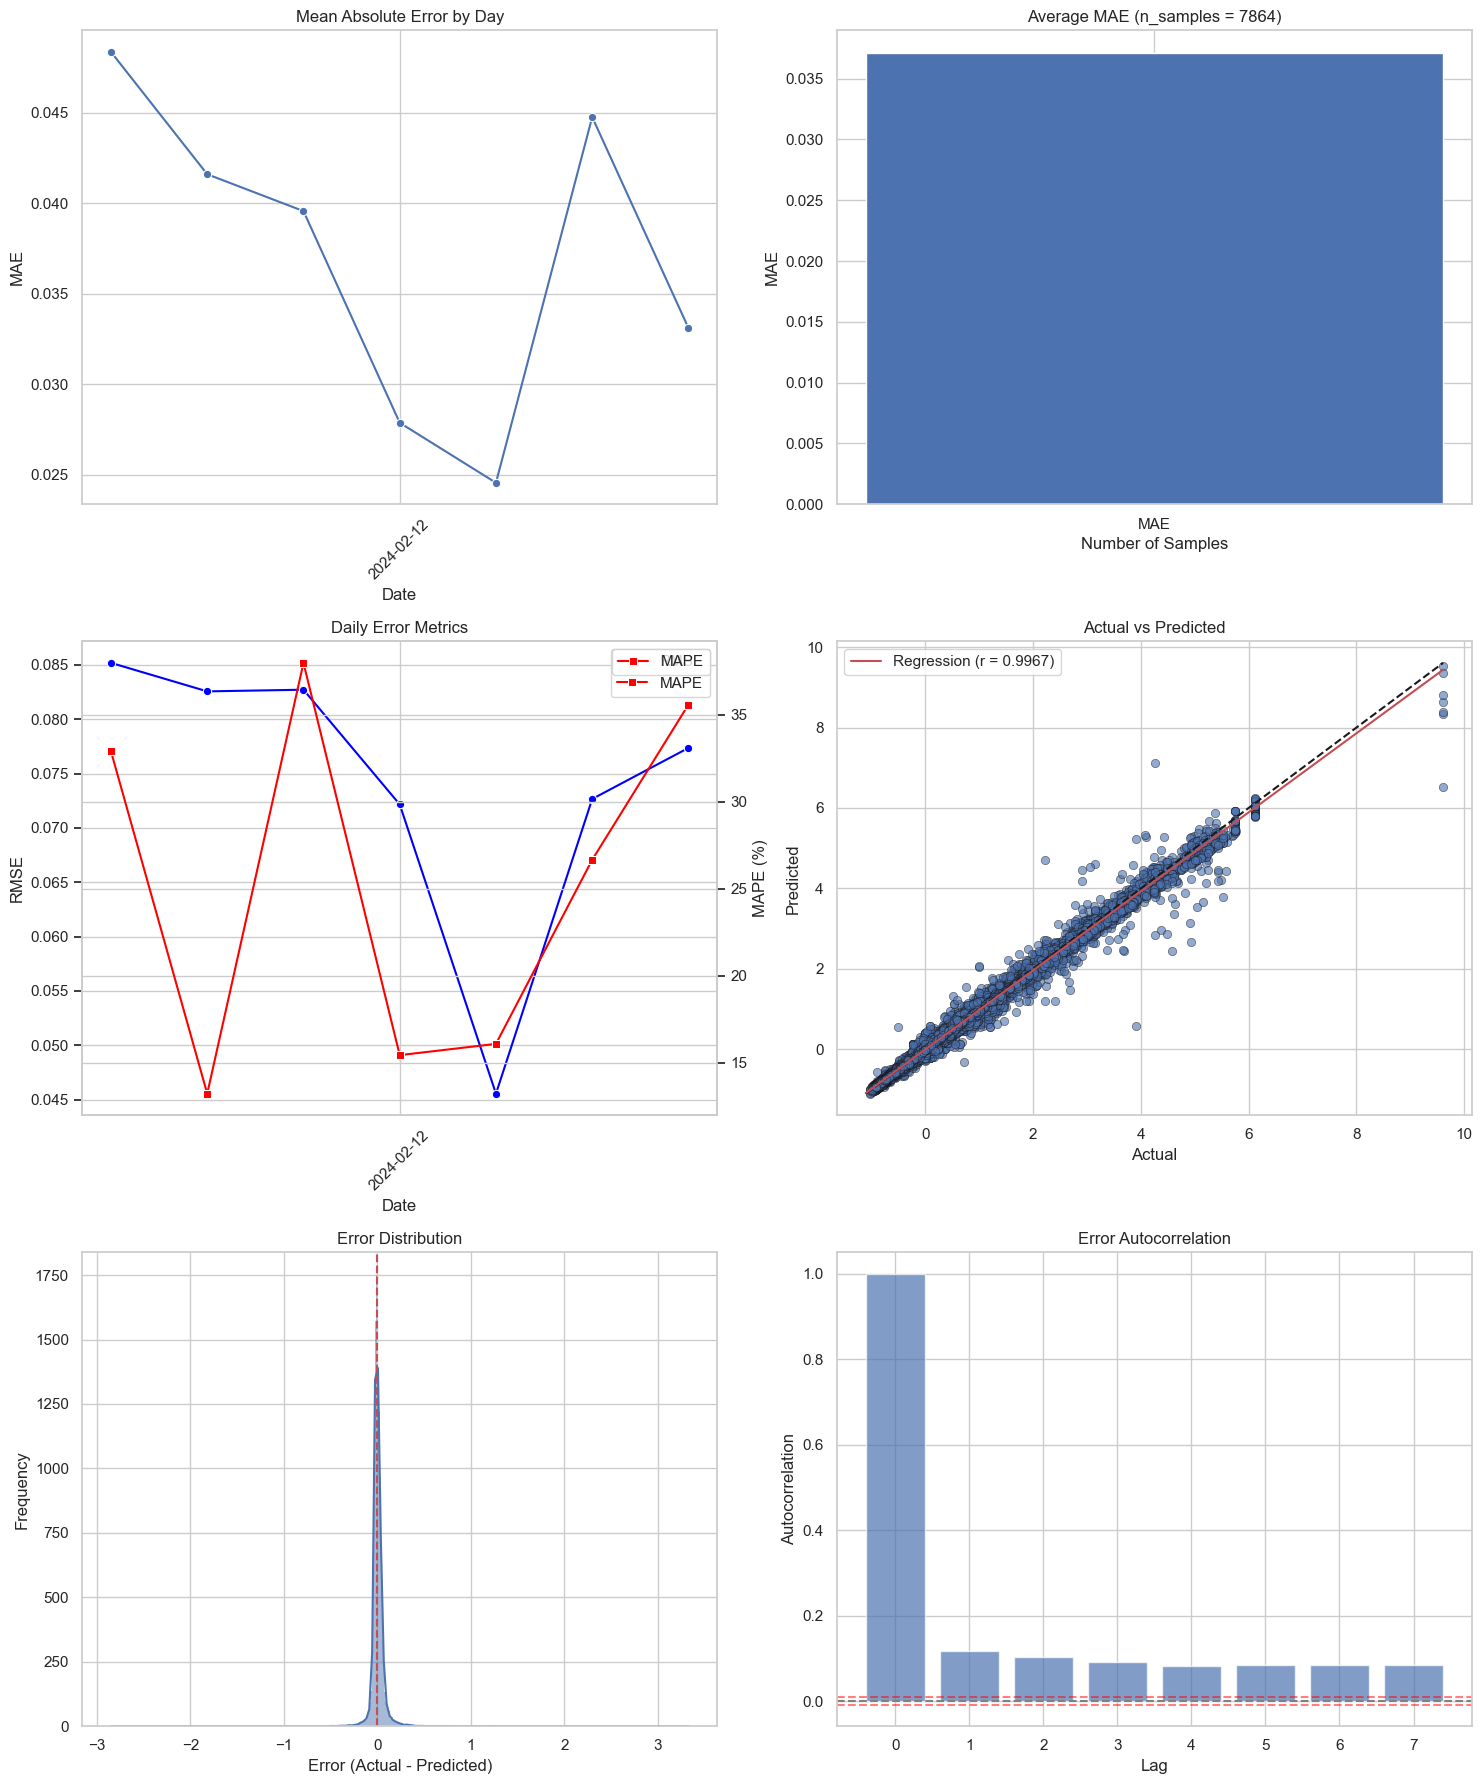

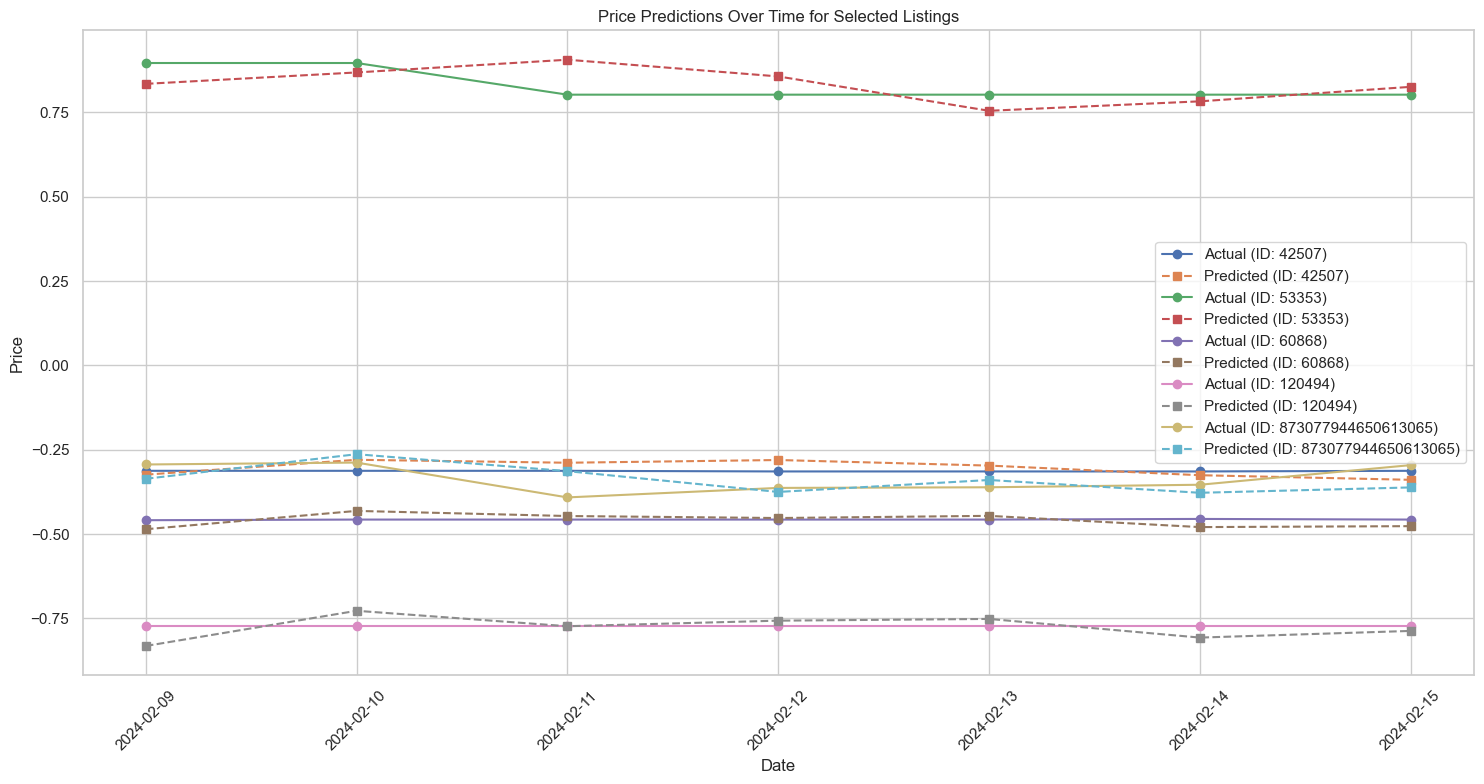

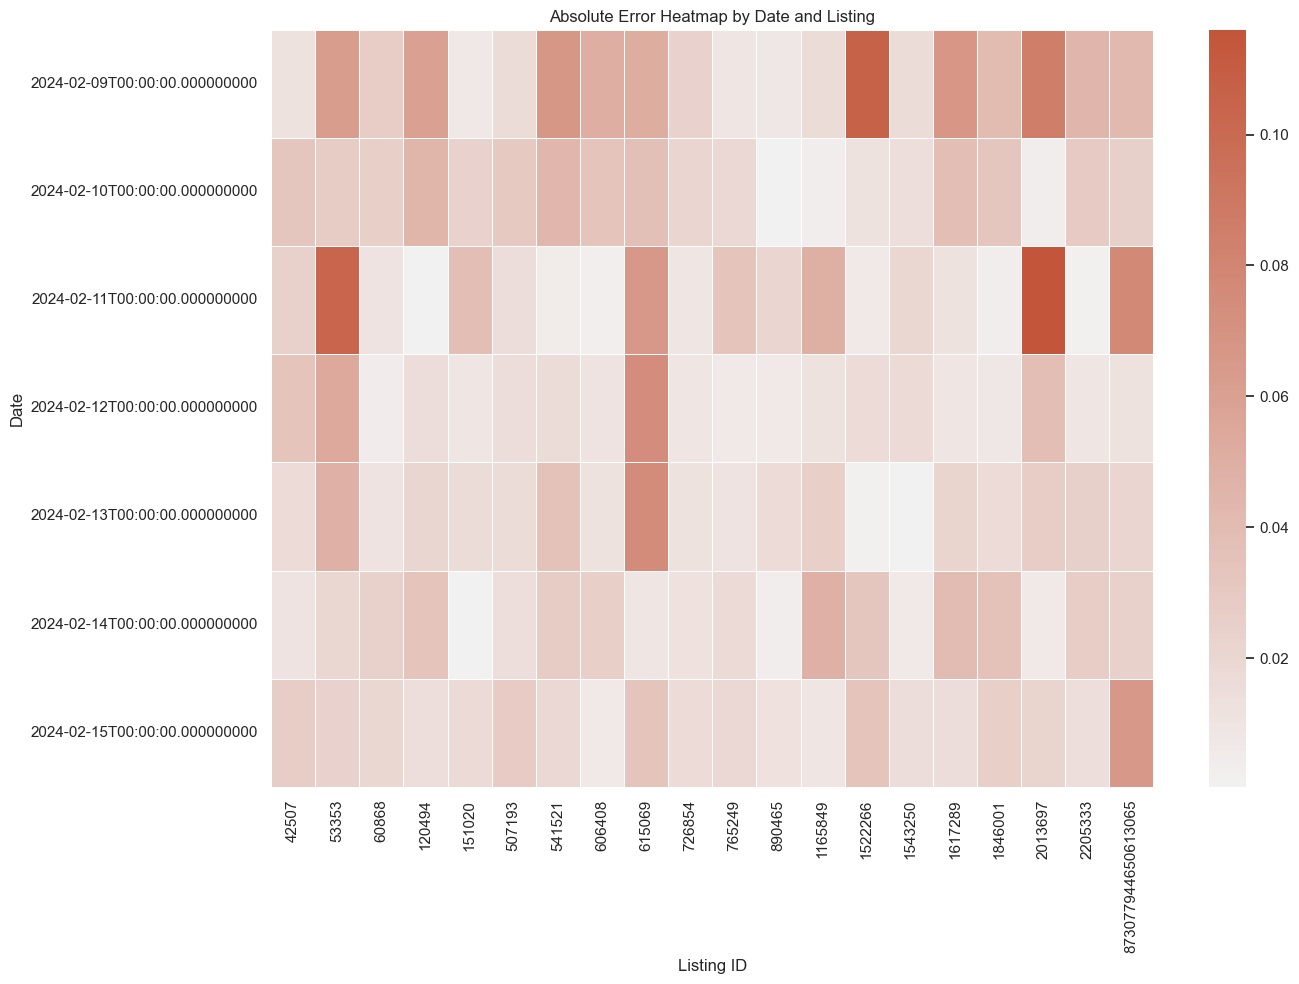

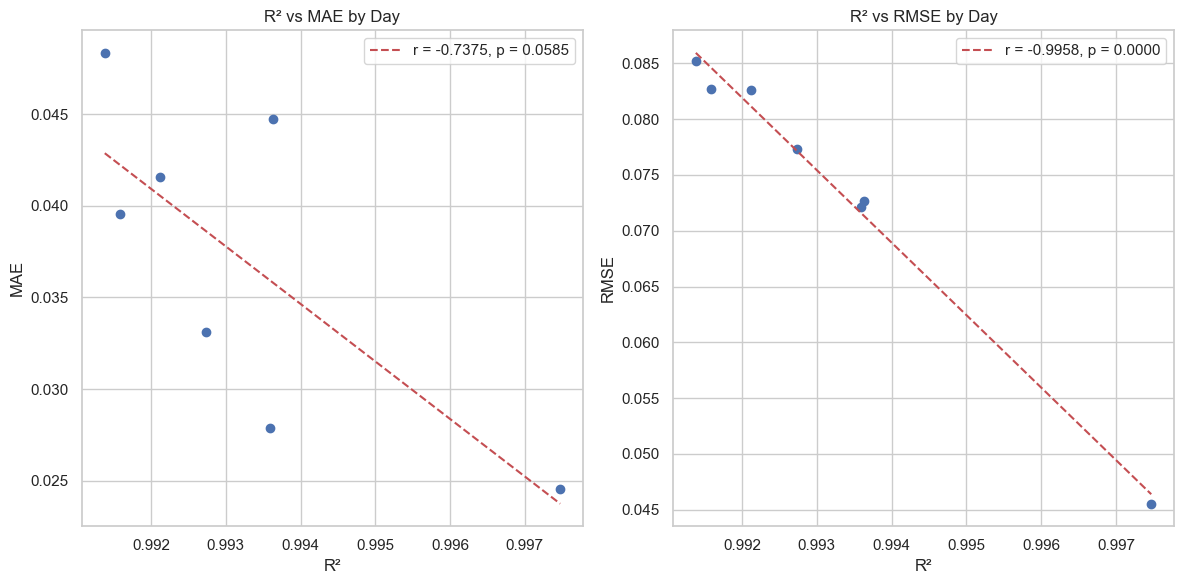

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# Load your neural network output data
def load_and_prepare_data(csv_file_path):
    """Load and prepare the neural network output data for visualization"""
    print(f"Loading data from {csv_file_path}")
    df = pd.read_csv(csv_file_path)
    
    # Convert date to datetime if it's not already
    if 'date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])
    
    # Calculate additional metrics if not already present
    if 'error' not in df.columns:
        df['error'] = df['price'] - df['predicted']
    
    if 'abs_error' not in df.columns:
        df['abs_error'] = np.abs(df['error'])
    
    if 'pct_error' not in df.columns:
        df['pct_error'] = np.abs(df['error'] / (df['price'] + 1e-8)) * 100
    
    # Add date_str for grouping if needed
    df['date_str'] = df['date'].dt.strftime('%Y-%m-%d')
    
    return df

def calculate_metrics(df):
    """Calculate various evaluation metrics for the model"""
    y_true = df['price']
    y_pred = df['predicted']
    
    # Calculate overall metrics
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'correlation': np.corrcoef(y_true, y_pred)[0, 1]
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day, group in df.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Calculate error autocorrelation
    errors = df['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    results = {
        'overall_metrics': overall_metrics,
        'daily_metrics': daily_metrics_df,
        'error_autocorrelation': error_autocorr
    }
    
    return results

def print_evaluation_summary(results):
    """Print a summary of the evaluation results"""
    overall = results['overall_metrics']
    daily = results['daily_metrics']
    error_autocorr = results.get('error_autocorrelation', [0] * 7)
    
    print("\n===== NEURAL NETWORK MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Correlation: {overall['correlation']:.4f}")
    
    print("\n=== Daily Performance ===")
    # Print a sample of the daily metrics (first 5 days, last 5 days)
    if len(daily) > 10:
        print("First 5 days:")
        print(daily.head(5)[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
        print("\nLast 5 days:")
        print(daily.tail(5)[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    else:
        print(daily[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")

def safe_linregress(x, y):
    """Safely perform linear regression with error handling for identical x values"""
    # Check if all x values are the same
    if len(set(x)) <= 1:
        print("Warning: All x values are identical, cannot perform linear regression")
        return None, None, None, None, None
    else:
        return linregress(x, y)

def plot_evaluation_results(df, results):
    """Create visualizations for model evaluation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = results['daily_metrics']
    error_autocorr = results['error_autocorrelation']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=daily_metrics['date'],
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 days
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Scatter plot of samples per day vs. MAE
    if len(set(daily_metrics['n_samples'])) > 1:  # Check if n_samples has multiple values
        axes[0, 1].scatter(daily_metrics['n_samples'], daily_metrics['mae'])
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = safe_linregress(
            daily_metrics['n_samples'], 
            daily_metrics['mae']
        )
        
        # Only plot regression line if regression was successful
        if slope is not None:
            x_line = np.array([daily_metrics['n_samples'].min(), daily_metrics['n_samples'].max()])
            y_line = slope * x_line + intercept
            axes[0, 1].plot(x_line, y_line, 'r--')
            axes[0, 1].set_title(f'Sample Size vs. MAE (r = {r_value:.4f})')
        else:
            axes[0, 1].set_title('Sample Size vs. MAE')
    else:
        # If all n_samples are the same, create a bar chart instead
        axes[0, 1].bar(['MAE'], [daily_metrics['mae'].mean()])
        axes[0, 1].set_title(f'Average MAE (n_samples = {daily_metrics["n_samples"].iloc[0]})')
    
    axes[0, 1].set_xlabel('Number of Samples')
    axes[0, 1].set_ylabel('MAE')
    
    # Plot 3: Daily RMSE and MAPE
    ax3 = axes[1, 0]
    ax3_twin = ax3.twinx()  # Create second y-axis
    
    # Plot RMSE on left axis
    sns.lineplot(
        x=daily_metrics['date'],
        y=daily_metrics['rmse'],
        marker='o',
        color='blue',
        label='RMSE',
        ax=ax3
    )
    
    # Plot MAPE on right axis
    sns.lineplot(
        x=daily_metrics['date'],
        y=daily_metrics['mape'],
        marker='s',
        color='red', 
        label='MAPE',
        ax=ax3_twin
    )
    
    ax3.set_title('Daily Error Metrics')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('RMSE')
    ax3_twin.set_ylabel('MAPE (%)')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Add combined legend
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Plot 4: Actual vs Predicted (with identity line)
    scatter = axes[1, 1].scatter(
        df['price'],
        df['predicted'],
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5
    )
    min_val = min(df['price'].min(), df['predicted'].min())
    max_val = max(df['price'].max(), df['predicted'].max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].set_xlabel('Actual')
    axes[1, 1].set_ylabel('Predicted')
    
    # Add a linear regression line
    if len(set(df['price'])) > 1:  # Check if price has multiple values
        slope, intercept, r_value, p_value, std_err = safe_linregress(df['price'], df['predicted'])
        if slope is not None:
            x_line = np.array([min_val, max_val])
            y_line = slope * x_line + intercept
            axes[1, 1].plot(x_line, y_line, 'r-', label=f'Regression (r = {r_value:.4f})')
            axes[1, 1].legend()
    
    # Plot 5: Error distribution
    sns.histplot(df['error'], kde=True, ax=axes[2, 0])
    axes[2, 0].axvline(0, color='r', linestyle='--')
    axes[2, 0].set_title('Error Distribution')
    axes[2, 0].set_xlabel('Error (Actual - Predicted)')
    axes[2, 0].set_ylabel('Frequency')
    
    # Plot 6: Error autocorrelation
    error_acf = np.concatenate([[1], error_autocorr])
    lags = range(len(error_acf))
    
    axes[2, 1].bar(lags, error_acf, alpha=0.7)
    axes[2, 1].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(df['error']))
    axes[2, 1].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[2, 1].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[2, 1].set_xlabel('Lag')
    axes[2, 1].set_ylabel('Autocorrelation')
    axes[2, 1].set_title('Error Autocorrelation')
    
    plt.tight_layout()
    plt.show()

def create_listing_time_series_plot(df, max_listings=5):
    """Create a time series plot of predictions for selected listings"""
    # Count observations per listing
    listing_counts = df['listing_id'].value_counts()
    
    # Check if we have any listings with multiple observations
    if listing_counts.max() <= 1:
        print("Warning: No listings with multiple time points, skipping time series plot")
        return
    
    # Select listings with most observations (up to max_listings)
    selected_listings = listing_counts.head(max_listings).index
    
    # Filter data for selected listings
    sample_data = df[df['listing_id'].isin(selected_listings)]
    
    # Plot
    plt.figure(figsize=(15, 8))
    
    for listing_id, group in sample_data.groupby('listing_id'):
        # Only plot if there are multiple time points
        if len(group) > 1:
            group = group.sort_values('date')
            plt.plot(
                group['date'], 
                group['price'], 
                'o-',
                label=f'Actual (ID: {listing_id})'
            )
            plt.plot(
                group['date'], 
                group['predicted'], 
                's--',
                label=f'Predicted (ID: {listing_id})'
            )
    
    plt.title('Price Predictions Over Time for Selected Listings')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    
    # Only show one entry per listing in the legend to avoid overcrowding
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:  # Check if there are any plot elements
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='best')
        plt.tight_layout()
        plt.show()
    else:
        plt.close()  # Close the figure if no plot elements were created

def create_error_heatmap_by_date_listing(df):
    """Create a heatmap of prediction errors by date and listing"""
    # Select top listings by observation count (limit to 20 for visibility)
    top_listings = df['listing_id'].value_counts().head(20).index
    
    # Filter data
    heatmap_data = df[df['listing_id'].isin(top_listings)].copy()
    
    # Check if we have enough data for a meaningful heatmap
    if len(heatmap_data['date_str'].unique()) < 2 or len(heatmap_data['listing_id'].unique()) < 2:
        print("Warning: Not enough unique dates or listings for heatmap, skipping")
        return
    
    # Create pivot table of errors
    pivot_data = heatmap_data.pivot_table(
        index='date_str', 
        columns='listing_id', 
        values='abs_error',
        aggfunc='mean'
    )
    
    # Sort by date
    pivot_data.index = pd.to_datetime(pivot_data.index)
    pivot_data = pivot_data.sort_index()
    
    # Plot
    plt.figure(figsize=(14, 10))
    mask = pivot_data.isna()
    
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(pivot_data, cmap=cmap, mask=mask, center=0, 
                annot=False, fmt=".2f", linewidths=.5)
    
    plt.title('Absolute Error Heatmap by Date and Listing')
    plt.ylabel('Date')
    plt.xlabel('Listing ID')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_r2_vs_errors(results):
    """Plot relationship between R² and error metrics"""
    daily = results['daily_metrics']
    
    # Check if we have enough data with non-NaN R² values
    valid_r2 = daily['r2'].dropna()
    if len(valid_r2) < 2:
        print("Warning: Not enough data points with valid R² for regression plot, skipping")
        return
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Plot R² vs MAE
    plt.subplot(1, 2, 1)
    plt.scatter(daily['r2'].dropna(), daily['mae'].loc[daily['r2'].dropna().index])
    plt.xlabel('R²')
    plt.ylabel('MAE')
    plt.title('R² vs MAE by Day')
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = safe_linregress(
        daily['r2'].dropna(), 
        daily['mae'].loc[daily['r2'].dropna().index]
    )
    if slope is not None:
        x_line = np.array([daily['r2'].min(), daily['r2'].max()])
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, 'r--', 
                label=f'r = {r_value:.4f}, p = {p_value:.4f}')
        plt.legend()
    
    # Plot R² vs RMSE
    plt.subplot(1, 2, 2)
    plt.scatter(daily['r2'].dropna(), daily['rmse'].loc[daily['r2'].dropna().index])
    plt.xlabel('R²')
    plt.ylabel('RMSE')
    plt.title('R² vs RMSE by Day')
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = safe_linregress(
        daily['r2'].dropna(), 
        daily['rmse'].loc[daily['r2'].dropna().index]
    )
    if slope is not None:
        x_line = np.array([daily['r2'].min(), daily['r2'].max()])
        y_line = slope * x_line + intercept
        plt.plot(x_line, y_line, 'r--', 
                label=f'r = {r_value:.4f}, p = {p_value:.4f}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Main function to run all visualizations
def visualize_neural_network_results(csv_file_path):
    """Run all visualizations on the neural network results"""
    # Load and prepare data
    df = load_and_prepare_data(csv_file_path)
    
    # Calculate metrics
    results = calculate_metrics(df)
    
    # Print summary
    print_evaluation_summary(results)
    
    # Create plots
    plot_evaluation_results(df, results)
    create_listing_time_series_plot(df)
    create_error_heatmap_by_date_listing(df)
    plot_r2_vs_errors(results)
    
    return df, results

# Example usage
if __name__ == "__main__":
    # Replace with the path to your CSV file
    csv_file_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    
    # Run all visualizations
    df, results = visualize_neural_network_results(csv_file_path)